In [1]:
# Import libraries
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Paths to datasets
train_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\train"
valid_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\valid"
test_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\test"
model_save_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\best_model_vgg.keras"

In [152]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),  # Color jitter
    fill_mode='nearest'
)

In [153]:
# Rescaling for validation and testing
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


Found 4921 images belonging to 5 classes.
Found 542 images belonging to 5 classes.
Found 559 images belonging to 5 classes.


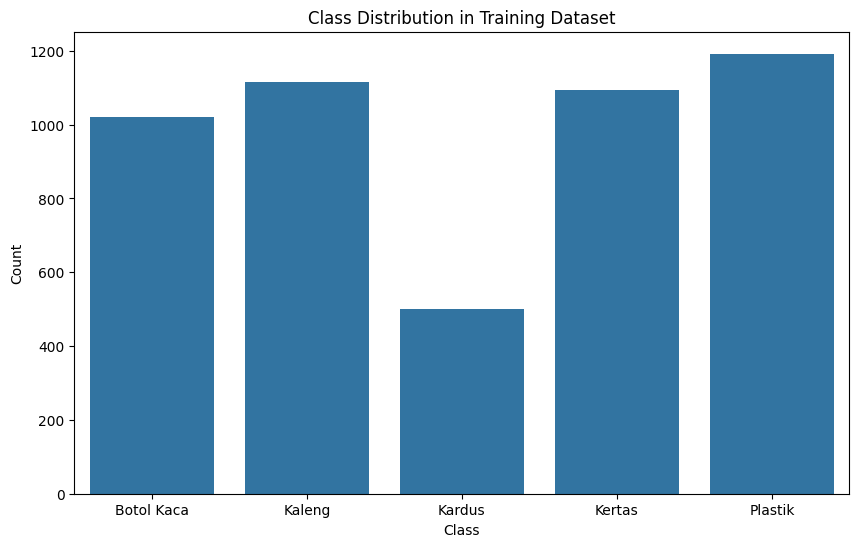

In [154]:
# Evaluate Dataset Balance
train_class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())
unique_classes, class_counts = np.unique(train_class_counts, return_counts=True)

# Plot Class Distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_labels, y=class_counts)
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [155]:
# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_class_counts),
    y=train_class_counts
)
class_weights = dict(enumerate(class_weights))

for cls, weight in class_weights.items():
    print(f"Class {cls}: {weight:.4f}")

# print("Class Weights:", class_weights)

Class 0: 0.9649
Class 1: 0.8819
Class 2: 1.9684
Class 3: 0.9005
Class 4: 0.8257


In [156]:
# Load pre-trained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [157]:
from tensorflow.keras.regularizers import l2


# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu',kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu',kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [158]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', save_best_only=True)

In [159]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stop, model_checkpoint]
)

c:\Program Files\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 479s 6s/step - accuracy: 0.2414 - loss: 2.5403 - val_accuracy: 0.2804 - val_loss: 2.2841
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 477s 6s/step - accuracy: 0.3599 - loss: 2.2152 - val_accuracy: 0.3284 - val_loss: 2.1551
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 474s 6s/step - accuracy: 0.4506 - loss: 1.9977 - val_accuracy: 0.3450 - val_loss: 2.0752
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 474s 6s/step - accuracy: 0.5344 - loss: 1.7767 - val_accuracy: 0.3948 - val_loss: 2.0294
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 475s 6s/step - accuracy: 0.5812 - loss: 1.6251 - val_accuracy: 0.4280 - val_loss: 2.0011
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 474s 6s/step - accuracy: 0.6035 - loss: 1.5077 - val_accuracy: 0.4446 - val_loss: 1.9499
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 473s 6s/step - accuracy: 0.6345 - loss: 1.4391 - val_accuracy: 0.4465 - val_loss: 1.9404
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 472s 6s/step - accuracy: 0.6468 - loss: 1.3747 - val_accuracy: 0.

In [160]:
# Fine-tuning: Unfreeze top layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [161]:
# Continue training with fine-tuning
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 499s 6s/step - accuracy: 0.8462 - loss: 0.6083 - val_accuracy: 0.6162 - val_loss: 1.4879
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 496s 6s/step - accuracy: 0.8764 - loss: 0.5507 - val_accuracy: 0.6144 - val_loss: 1.4235
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 496s 6s/step - accuracy: 0.8738 - loss: 0.5282 - val_accuracy: 0.6439 - val_loss: 1.3027
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 498s 6s/step - accuracy: 0.8932 - loss: 0.4797 - val_accuracy: 0.6328 - val_loss: 1.3496
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 495s 6s/step - accuracy: 0.8992 - loss: 0.4788 - val_accuracy: 0.6199 - val_loss: 1.4882
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 499s 6s/step - accuracy: 0.8990 - loss: 0.4821 - val_accuracy: 0.6347 - val_loss: 1.4230
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 495s 6s/step - accuracy: 0.9188 - loss: 0.4287 - val_accuracy: 0.6679 - val_loss: 1.4065
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 496s 6s/step - accuracy: 0.9218 - loss: 0.4246 - val_accuracy: 0.6494 - v

In [162]:
model.save(r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\final_model_vgg.h5")

In [163]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.7442 - loss: 1.0133
Test Accuracy: 67.80%
Test Loss: 1.2161


In [164]:
# Classification Report and Confusion Matrix
test_preds = model.predict(test_generator)
test_pred_classes = np.argmax(test_preds, axis=1)
true_classes = test_generator.classes
class_labels = list(train_generator.class_indices.keys())

# Classification Report
print(classification_report(true_classes, test_pred_classes, target_names=class_labels))

9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step
              precision    recall  f1-score   support

  Botol Kaca       0.74      0.81      0.77       134
      Kaleng       0.76      0.88      0.81       112
      Kardus       0.65      0.66      0.65        61
      Kertas       0.63      0.48      0.54       126
     Plastik       0.57      0.58      0.58       126

    accuracy                           0.68       559
   macro avg       0.67      0.68      0.67       559
weighted avg       0.67      0.68      0.67       559



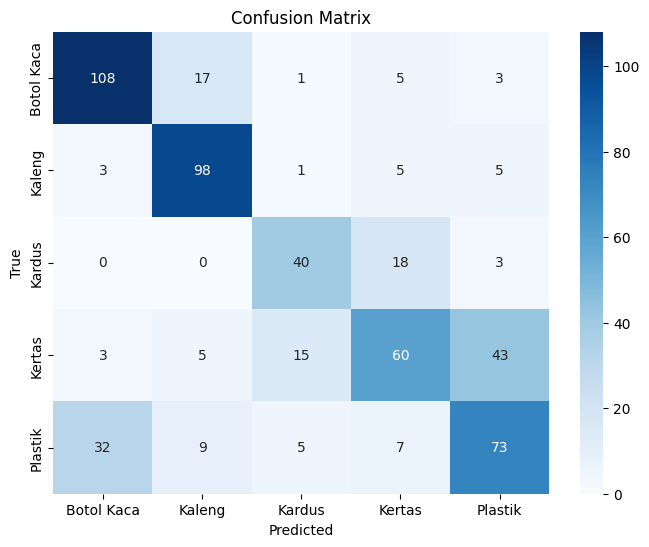

In [165]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

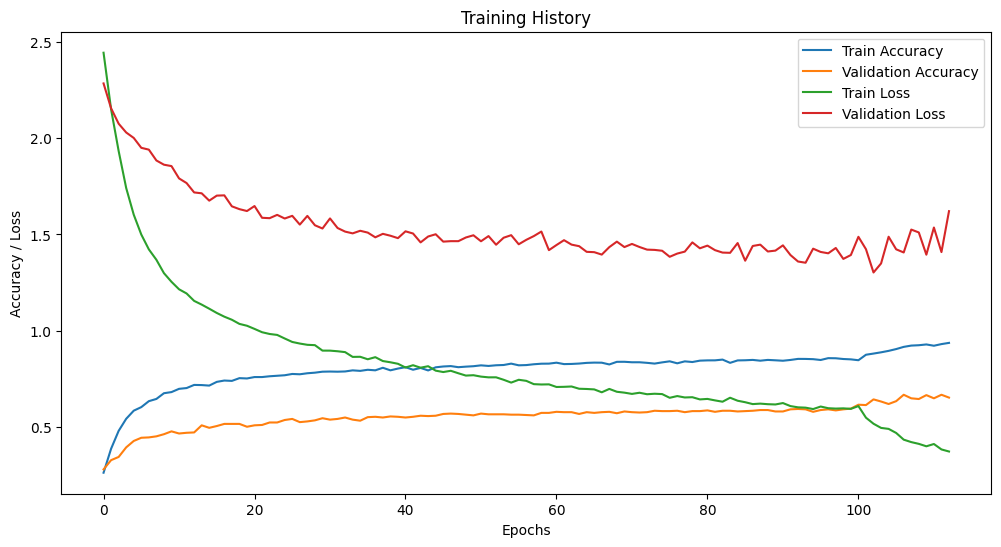

In [166]:
# Visualization of training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


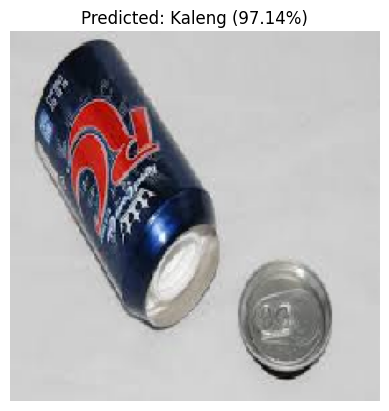

In [169]:
# Predict a single image
def predict_image(image_path, model, class_labels):
    img = load_img(image_path, target_size=(224, 224))  # Resize image
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch
    
    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    
    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.show()

# Example: Predict a single image
test_image_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\test\Kaleng\R_2045.jpg"
predict_image(test_image_path, model, class_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


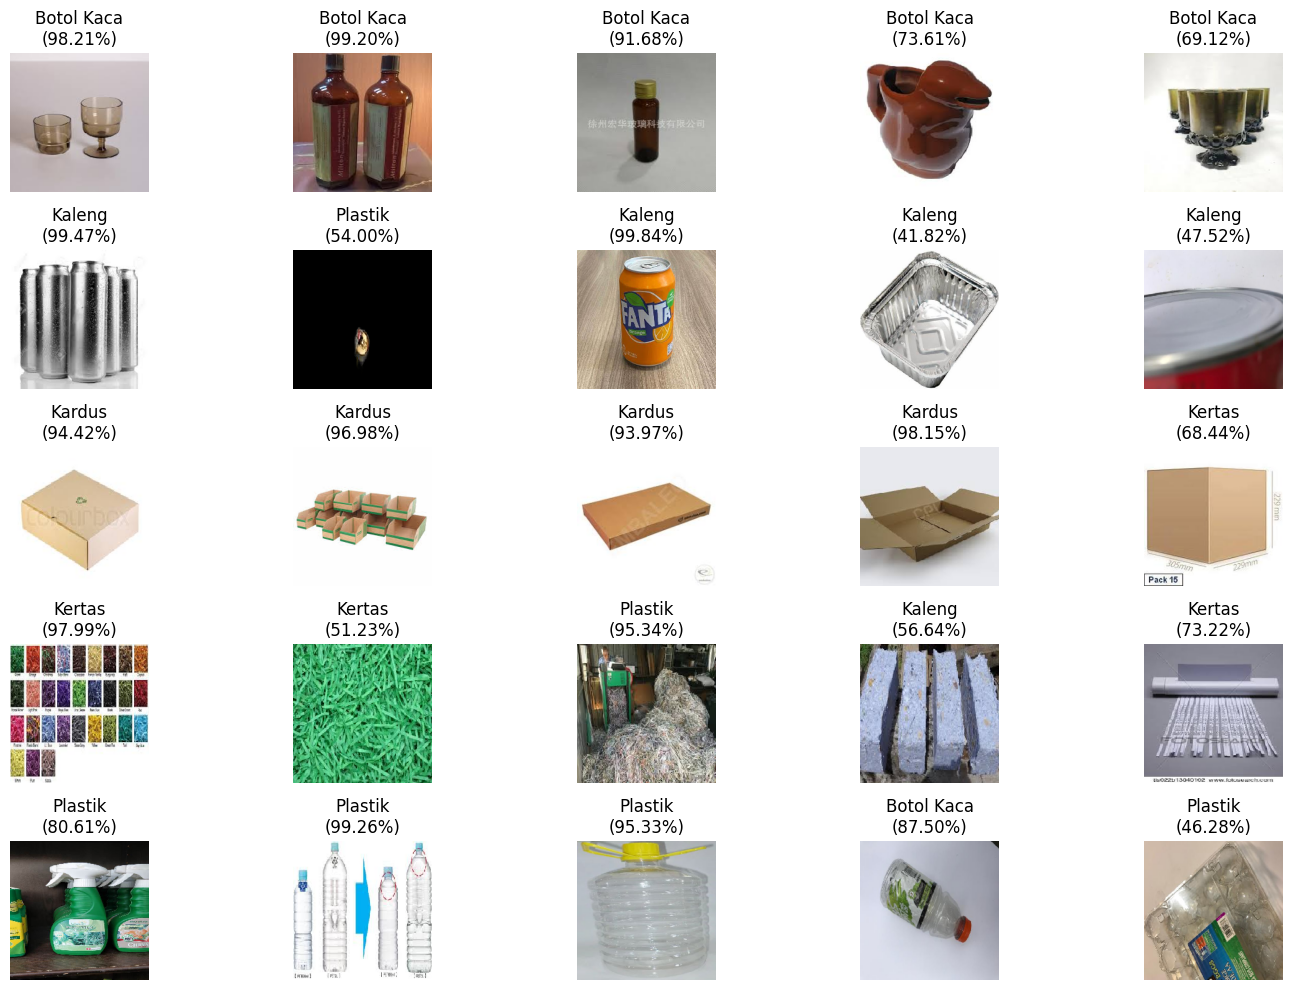

In [168]:
# Predict batch of images
def predict_batch_images(test_path, model, class_labels, num_images=5):
    test_categories = os.listdir(test_path)
    plt.figure(figsize=(15, 10))
    
    count = 0
    for category in test_categories:
        category_path = os.path.join(test_path, category)
        images = os.listdir(category_path)[:num_images]
        
        for image_name in images:
            img_path = os.path.join(category_path, image_name)
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # Predict
            prediction = model.predict(img_array)
            predicted_class = class_labels[np.argmax(prediction)]
            confidence = np.max(prediction) * 100
            
            # Display the image and prediction
            plt.subplot(len(test_categories), num_images, count + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{predicted_class}\n({confidence:.2f}%)")
            count += 1
    plt.tight_layout()
    plt.show()

# Example: Predict a batch of images
predict_batch_images(test_path, model, class_labels, num_images=5)


NameError: name 'class_labels' is not defined